## Part 2: Lane Detection


a) Median Smoothing Filter


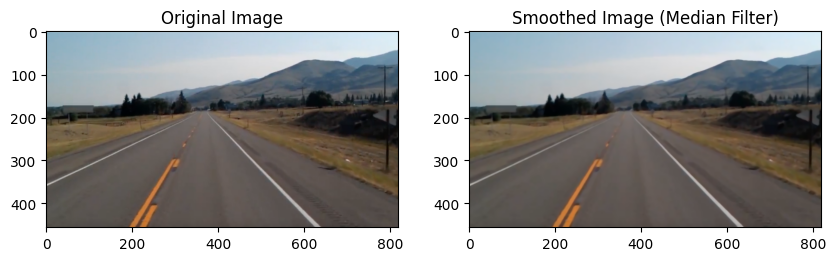

In [274]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Load the image
image = cv2.imread('image.png')

# Convert to RGB (since OpenCV reads in BGR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


# Apply a 2D median filter with a kernel size of 5
smoothed_image = cv2.medianBlur(image, 5)

# Display the original and smoothed images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image)

plt.subplot(1, 2, 2)
plt.title('Smoothed Image (Median Filter)')
plt.imshow(smoothed_image)
plt.show()


b) Edge Detectiion: Canny's Algorithm


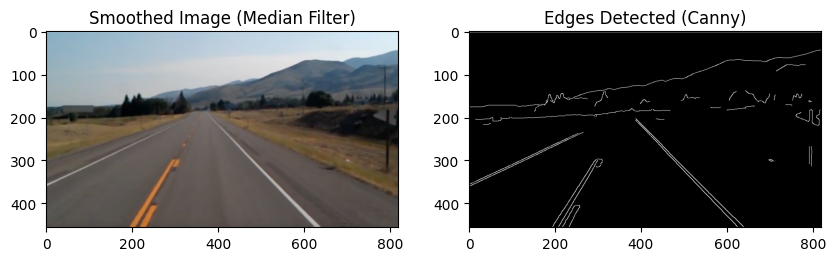

In [275]:
edges= cv2.Canny(smoothed_image, threshold1=100, threshold2=200)

# Display the smoothed image and the edges
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Smoothed Image (Median Filter)')
plt.imshow(smoothed_image, cmap='gray')

plt.subplot(1, 2, 2)
plt.title('Edges Detected (Canny)')
plt.imshow(edges, cmap='gray')
plt.show()

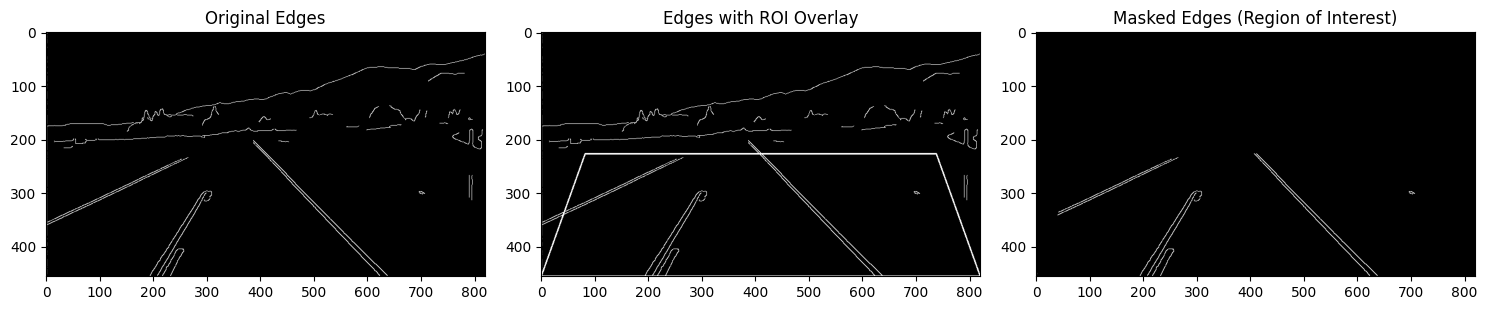

In [276]:
# Assuming 'edges' is the edge-detected image from the Canny algorithm
height, width = edges.shape

# Define the polygon (region of interest) vertices
# Adjust the coordinates to focus on the road area in your images
roi_vertices = np.array([[
    (int(width * 0), int(height )),  # Bottom left extended further to the left
    (int(width * 1), int(height )),  # Bottom right
    (int(width * 0.9), int(height * 0.5)),  # Top right
    (int(width * 0.1), int(height * 0.5))   # Top left
]], dtype=np.int32)

# Create a blank mask the same size as the edge-detected image
mask = np.zeros_like(edges)

# Fill the polygon on the mask with white (255)
cv2.fillPoly(mask, roi_vertices, 255)

# Apply the mask to the edge-detected image
masked_edges = cv2.bitwise_and(edges, mask)

# Draw the region of interest on the original edge-detected image for visualization
edges_with_roi = edges.copy()
cv2.polylines(edges_with_roi, roi_vertices, isClosed=True, color=255, thickness=2)

# Display the results
plt.figure(figsize=(15, 7))
plt.subplot(1, 3, 1)
plt.title('Original Edges')
plt.imshow(edges, cmap='gray')

plt.subplot(1, 3, 2)
plt.title('Edges with ROI Overlay')
plt.imshow(edges_with_roi, cmap='gray')

plt.subplot(1, 3, 3)
plt.title('Masked Edges (Region of Interest)')
plt.imshow(masked_edges, cmap='gray')

plt.tight_layout()
plt.show()

c) Hough Transform


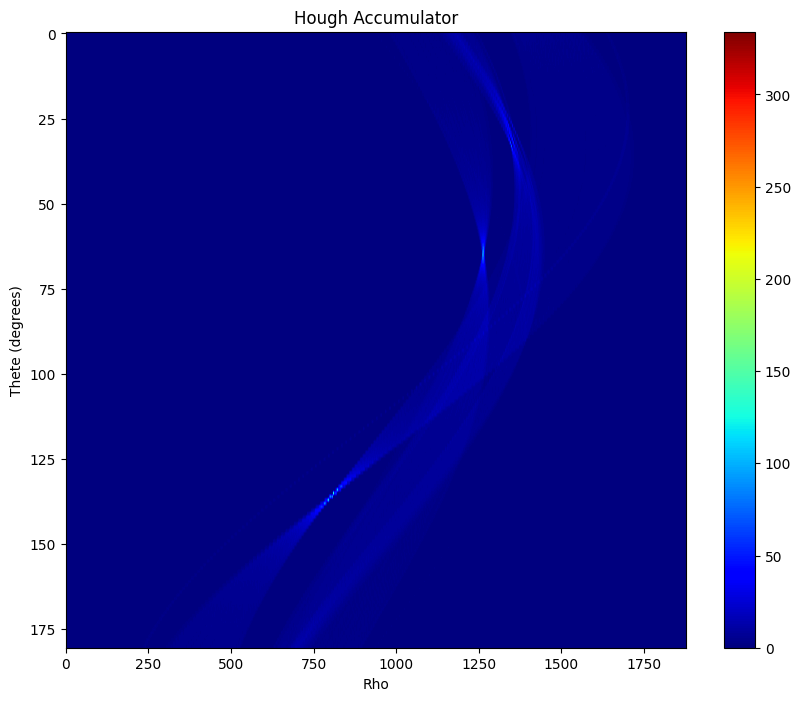

In [277]:
# Create an empty accumulator array
theta = np.linspace(0, 180, 181)
rho = np.arange(-np.sqrt(image.shape[0]**2 + image.shape[1]**2), np.sqrt(image.shape[0]**2 + image.shape[1]**2))
accumulator = np.zeros((len(rho), len(theta)), dtype=np.uint64)

# Iterate through the edge pixels and update the accumulator
for y, x in zip(*np.where(masked_edges > 0)):
    for t in theta:
        r = x * np.cos(np.deg2rad(t)) + y * np.sin(np.deg2rad(t))
        r_idx = np.abs(rho - r).argmin()
        accumulator[r_idx, int(t)] += 1

# Plot the accumulator array as an image
plt.figure(figsize=(10, 8))
plt.imshow(accumulator.T, cmap='jet', aspect='auto')
plt.title('Hough Accumulator')
plt.xlabel('Rho')
plt.ylabel('Thete (degrees)')
plt.colorbar()
plt.show()

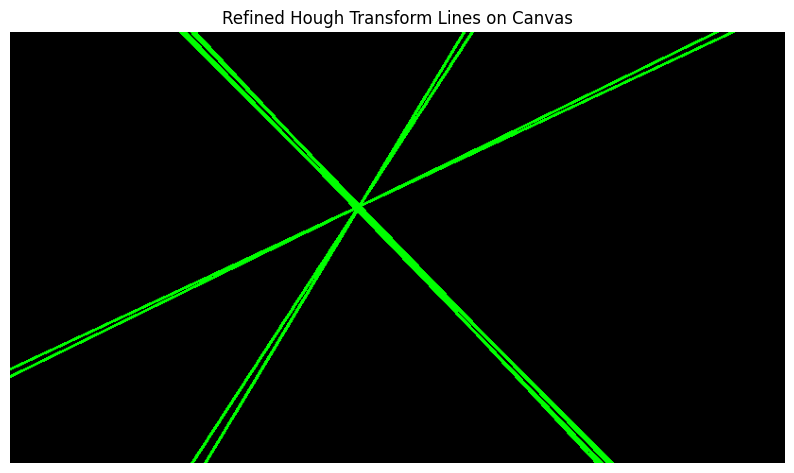

In [278]:
# Find the peaks in the accumulator array
threshold = 0.4 * np.max(accumulator)
peaks = np.where(accumulator > threshold)

# Extract the corresponding rho and theta values for the peaks
peak_rho = rho[peaks[0]]
peak_theta = theta[peaks[1]]

def non_maximum_suppression(peak_rho, peak_theta, threshold_rho=2, threshold_theta=2):
    suppressed_rho = []
    suppressed_theta = []
    
    for i in range(len(peak_rho)):
        # Check if this peak is too close to any of the previously accepted peaks
        is_suppressed = False
        for srho, stheta in zip(suppressed_rho, suppressed_theta):
            if abs(peak_rho[i] - srho) < threshold_rho and abs(peak_theta[i] - stheta) < threshold_theta:
                is_suppressed = True
                break
        
        if not is_suppressed:
            suppressed_rho.append(peak_rho[i])
            suppressed_theta.append(peak_theta[i])
    
    return suppressed_rho, suppressed_theta

# Call the non-maximum suppression function
refined_rho, refined_theta = non_maximum_suppression(peak_rho, peak_theta)
# Create a blank canvas to draw the lines
canvas = np.zeros_like(image)

# Draw the refined lines on the canvas
for i in range(len(refined_rho)):
    a = np.cos(np.deg2rad(refined_theta[i]))
    b = np.sin(np.deg2rad(refined_theta[i]))
    x0 = a * refined_rho[i]
    y0 = b * refined_rho[i]
    x1 = int(x0 + 1000 * (-b))
    y1 = int(y0 + 1000 * (a))
    x2 = int(x0 - 1000 * (-b))
    y2 = int(y0 - 1000 * (a))
    cv2.line(canvas, (x1, y1), (x2, y2), (0, 255, 0), 2)


# Display the lines on the blank canvas
plt.figure(figsize=(10, 8))
plt.imshow(canvas)
plt.title('Refined Hough Transform Lines on Canvas')
plt.axis('off')  # Hide axes
plt.show()

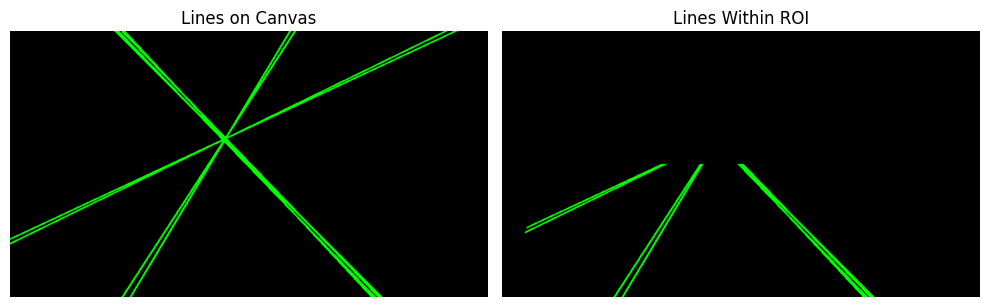

In [279]:
# Create a blank canvas to draw the lines within the ROI
masked_canvas = np.zeros_like(canvas)

# Draw the refined lines on the blank canvas
for i in range(len(refined_rho)):
    a = np.cos(np.deg2rad(refined_theta[i]))
    b = np.sin(np.deg2rad(refined_theta[i]))
    x0 = a * refined_rho[i]
    y0 = b * refined_rho[i]
    x1 = int(x0 + 1000 * (-b))
    y1 = int(y0 + 1000 * (a))
    x2 = int(x0 - 1000 * (-b))
    y2 = int(y0 - 1000 * (a))
    
    # Draw the line on the masked canvas
    cv2.line(masked_canvas, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Apply the mask to the canvas with lines
masked_lines = cv2.bitwise_and(masked_canvas, masked_canvas, mask=mask)

# Display the results
plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.title('Lines on Canvas')
plt.imshow(masked_canvas)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Lines Within ROI')
plt.imshow(masked_lines)
plt.axis('off')

plt.tight_layout()
plt.show()

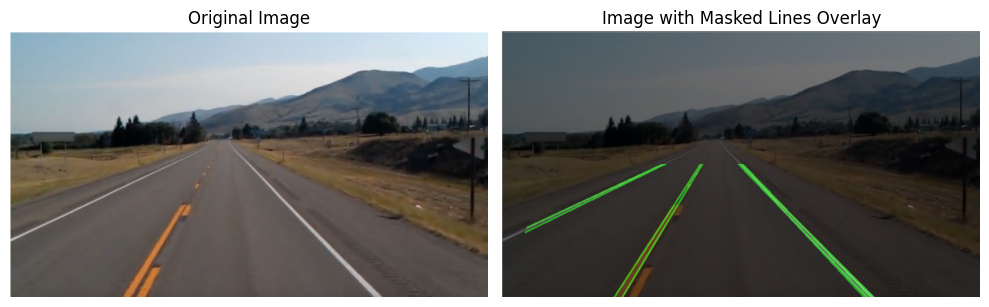

In [280]:
# Blend the masked lines with the original image
# You can adjust the alpha parameter to change the transparency of the lines
alpha = 0.5  # Weight for the lines
beta = 1.0 - alpha  # Weight for the original image
blended_image = cv2.addWeighted(image, beta, masked_lines, alpha, 0)

# Display the original image and the blended result
plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Image with Masked Lines Overlay')
plt.imshow(blended_image)
plt.axis('off')

plt.tight_layout()
plt.show()

For Explaination

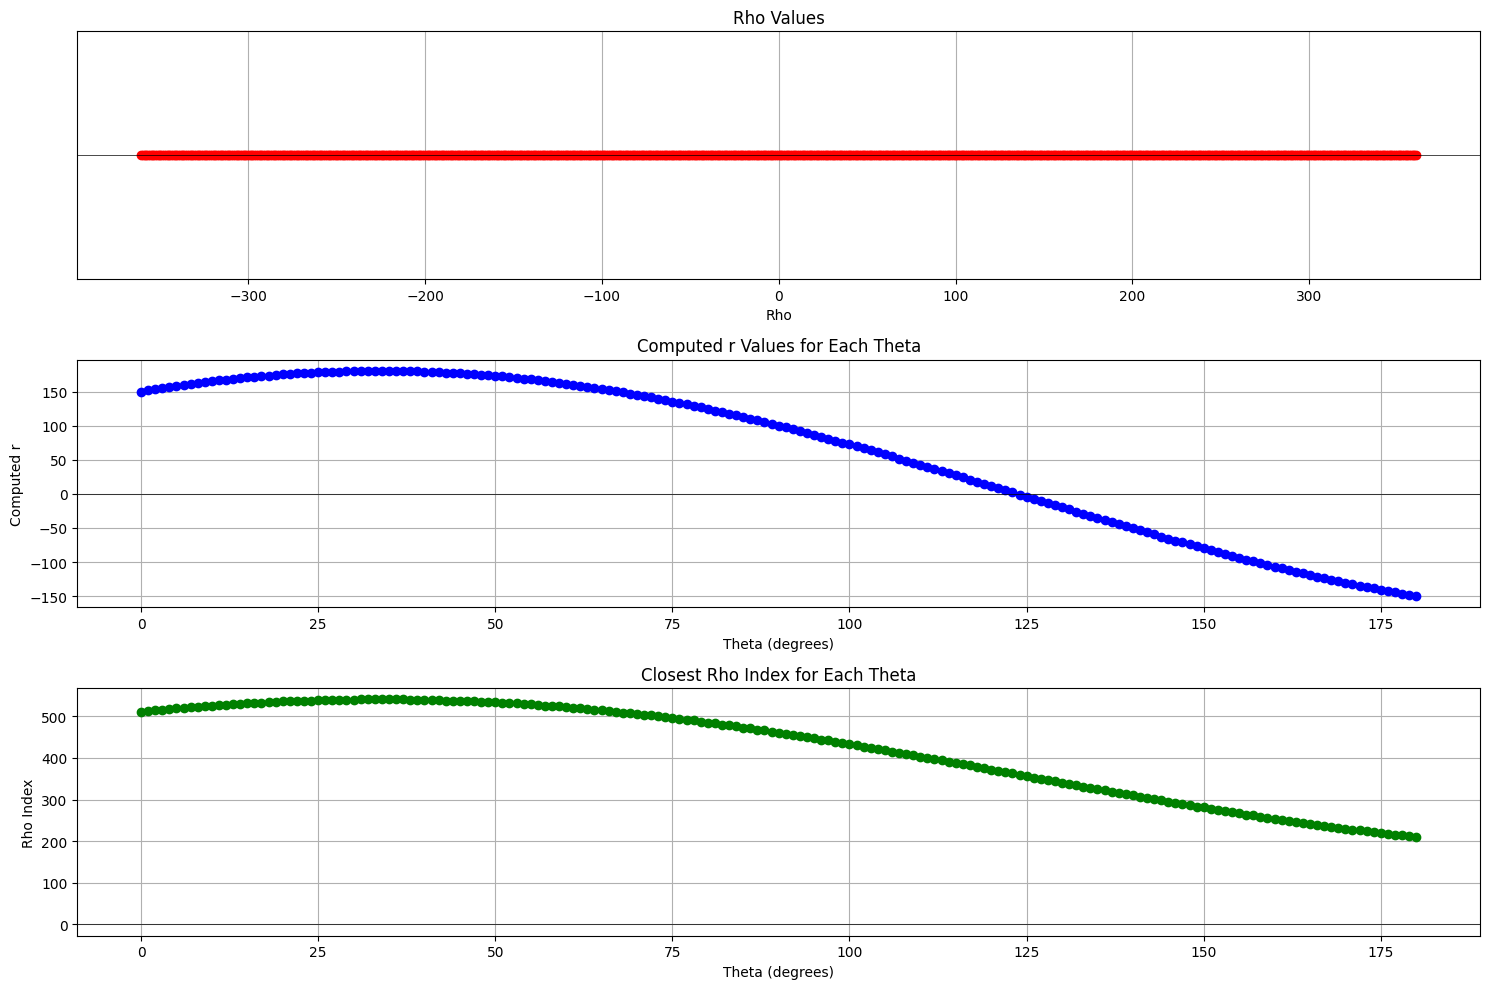

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Assuming image dimensions
# image_height = 200
# image_width = 300

# # Generate rho values based on image dimensions
# rho = np.arange(-np.sqrt(image_height**2 + image_width**2), np.sqrt(image_height**2 + image_width**2))

# # Define a specific edge pixel (x, y)
# x, y = 150, 100  # Example edge pixel coordinates

# # Compute r values for all theta angles
# theta = np.linspace(0, 180, 181)
# r = x * np.cos(np.deg2rad(theta)) + y * np.sin(np.deg2rad(theta))

# # Find the closest rho index for each calculated r
# r_idx = np.abs(rho[:, None] - r).argmin(axis=0)  # Indices for each theta angle

# # Visualization of rho, r, and r_idx
# plt.figure(figsize=(15, 10))

# # Plot 1: Rho values
# plt.subplot(3, 1, 1)
# plt.plot(rho, np.zeros_like(rho), 'r', marker='o', label='Rho Values')
# plt.title('Rho Values')
# plt.xlabel('Rho')
# plt.yticks([])  # Hide y-axis
# plt.axhline(0, color='black', lw=0.5)
# plt.grid()

# # Plot 2: Computed r values
# plt.subplot(3, 1, 2)
# plt.plot(theta, r, 'b', marker='o', label='Computed r for (x,y) = (150,100)')
# plt.title('Computed r Values for Each Theta')
# plt.xlabel('Theta (degrees)')
# plt.ylabel('Computed r')
# plt.axhline(0, color='black', lw=0.5)
# plt.grid()

# # Plot 3: r_idx visualization
# plt.subplot(3, 1, 3)
# plt.plot(theta, r_idx, 'g', marker='o', label='Closest Rho Index')
# plt.title('Closest Rho Index for Each Theta')
# plt.xlabel('Theta (degrees)')
# plt.ylabel('Rho Index')
# plt.axhline(0, color='black', lw=0.5)
# plt.grid()

# plt.tight_layout()
# plt.show()
